## **PRACTICAL SESSION 1** — Deep Learning for predictive maintenance

The dataset used is the **AI4I 2020** Predictive Maintenance Dataset, which contains 10,000 instances of industrial sensor data. Each instance represents the operating condition of a machine and is associated with a label indicating whether a failure has occurred and, if so, what type of failure it is.

The 5 possible labels are:



*   **TWF**: Tool Wear Failure
*   **HDF**: Heat Dissipation Failure
*   **PWF**: Power Failure
*   **OSF**: Overstrain Failure
*   **RNF**: Random Failure


The data is available on eCAMPUS as CSV file called: "ai4i2020.csv"



## **PRACTICAL SESSION Goal** — Create a deep leanring model allowing to realize a predictive maintenance mission

## **1 - Analysis of the dataset**



All libraries used ***SHOULD BE PLACED*** in the code cell below

In [1]:
# List management
import numpy as np
# Dataframe management
import pandas as pd
# Drawing plot
import matplotlib.pyplot as plt
# AI training
import tensorflow as tf
!pip install tensorflow==2.12.0
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from collections import Counter
from imblearn.over_sampling import SMOTE

**QUESTION:** Load dataset and display some lines of the csv file.

In [2]:
# Get data from ai4i2020.csv on my drive
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ai4i2020.csv")

data.head() # Print first lines

Mounted at /content/drive


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [3]:
def add_text_to_bar_chart(text_list, bar):
    """
    Input :
      - Text for each bar (text_list : /)
      - bar chart (bar : /)

    Output : None

    Print value on top of each bar.
    """
    i =0
    for bar in chart:
      plt.text(bar.get_x()+bar.get_width()/2, bar.get_height()+1, text_list[i], horizontalalignment="center")
      i +=1

**QUESTION:** Display the distribution of machine failures and non-failures with a bar graph.

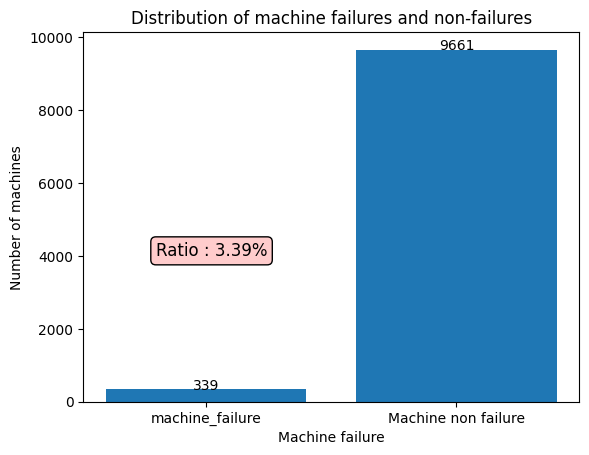

In [4]:
# Sort machine with failure or not
machine_non_failure = data[data['Machine failure'] == 0]
machine_failure = data[data['Machine failure'] == 1]

# Print chart
chart = plt.bar(["machine_failure", "Machine non failure"], [len(machine_failure),len(machine_non_failure)], width=0.8)
plt.title("Distribution of machine failures and non-failures")
plt.xlabel("Machine failure")
plt.ylabel("Number of machines")
plt.text(-0.2, 4000, "Ratio : " + str(round(100*len(machine_failure)/(len(machine_non_failure)+len(machine_failure)), 3)) + "%", fontsize=12, bbox=dict(boxstyle="round",ec=(0, 0, 0),fc=(1., 0.8, 0.8)))

add_text_to_bar_chart([len(machine_failure), len(machine_non_failure)], chart)

**ANALYSIS QUESTION:** What do you observe?

**Analyse**

The dataset is composed of 10k machines :  
- 339 with a failure : machine_failure = 1
- 9661 with no failure :  machine_failure = 0
The ratio is 3.39% (machine_failure/(machine_failure+machine_non_failure)

**Conclusion**

So machine with failure is under-represented. This can affect the training of AI and add a bias on our model.

**ANALYSIS QUESTION:** What will be the consequence of this phenomenon on the model's learning?

The under-representation of failure machine will affect badly our results. The model will overfit or underfit, due to a bias.

**QUESTION:** Create a bar chart showing the distribution of different failure types (TWF, HDF, PWF, OSF, RNF). Display the exact values above each bar in the chart."

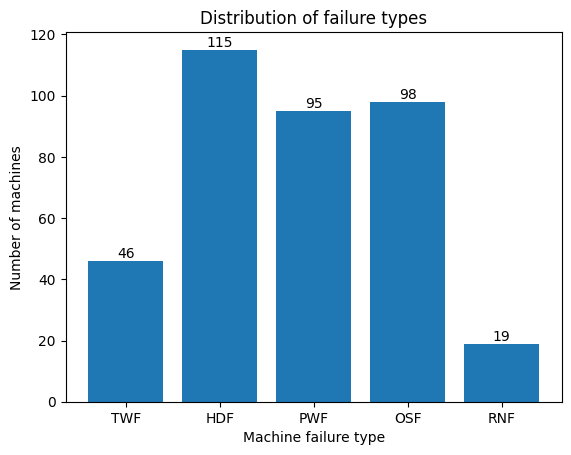

In [6]:
# Sort machine failure
machine_TWF = data[data['TWF'] == 1]
machine_HDF = data[data['HDF'] == 1]
machine_PWF = data[data['PWF'] == 1]
machine_OSF = data[data['OSF'] == 1]
machine_RNF = data[data['RNF'] == 1]

# Print chart
chart = plt.bar(["TWF", "HDF", "PWF", "OSF", "RNF"], [len(machine_TWF),len(machine_HDF), len(machine_PWF), len(machine_OSF), len(machine_RNF)], width=0.8)
plt.title("Distribution of failure types")
plt.xlabel("Machine failure type")
plt.ylabel("Number of machines")

add_text_to_bar_chart([len(machine_TWF),len(machine_HDF), len(machine_PWF), len(machine_OSF), len(machine_RNF)], chart)

**ANALYSIS QUESTION:** What do you observe?

**Analyse**

In the dataset error not homogeneous. For example, TWF and RNF are under-represented. Moreover, RNF is a Random Failure. We cannot use this data to train our model, because RANDOM failure, so unpredictable by definition.

**Conclusion**

The not homogeneous dataset of failure, can add bias to our model and affet badly our result. We need to erase RNF data to clean our database and homogenize our failure error.

**QUESTION:** Create a bar chart showing the distribution of failure types (TWF, HDF, PWF, OSF, RNF) among machines that experienced a failure (Machine failure == 1). Additionally, add a "No Specific Failure" category to count cases where a machine failed but no specific failure type was recorded. Display the exact values above each bar in the chart."

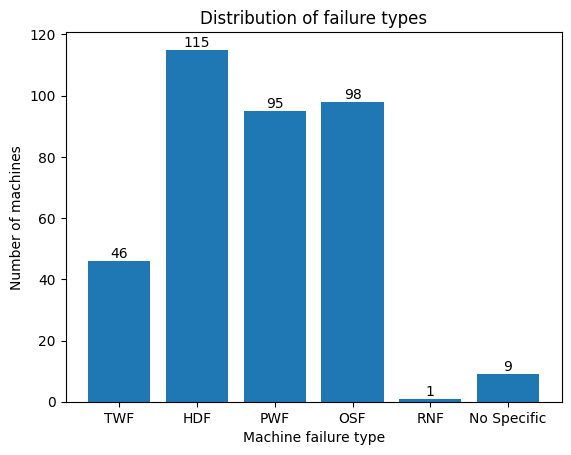

In [7]:
# Sort machine failure in the dataset of machine_failure = 1
machine_TWF = data[data['Machine failure'] == 1]
machine_TWF = machine_TWF[machine_TWF['TWF'] == 1]
machine_HDF = data[data['Machine failure'] == 1]
machine_HDF = machine_HDF[machine_HDF['HDF'] == 1]
machine_PWF = data[data['Machine failure'] == 1]
machine_PWF = machine_PWF[machine_PWF['PWF'] == 1]
machine_OSF = data[data['Machine failure'] == 1]
machine_OSF = machine_OSF[machine_OSF['OSF'] == 1]
machine_RNF = data[data['Machine failure'] == 1]
machine_RNF = machine_RNF[machine_RNF['RNF'] == 1]

# Search machine with no failure and a machine_failure = 1
machine_no_specific_failure = data[data['Machine failure'] == 1]
machine_no_specific_failure = machine_no_specific_failure[machine_no_specific_failure['TWF'] == 0]
machine_no_specific_failure = machine_no_specific_failure[machine_no_specific_failure['HDF'] == 0]
machine_no_specific_failure = machine_no_specific_failure[machine_no_specific_failure['PWF'] == 0]
machine_no_specific_failure = machine_no_specific_failure[machine_no_specific_failure['OSF'] == 0]
machine_no_specific_failure = machine_no_specific_failure[machine_no_specific_failure['RNF'] == 0]

# Keep this list for later
no_specific_failure_line = []
machine_no_specific_failure_array = np.array(machine_no_specific_failure[1:])

for line in machine_no_specific_failure_array:
  no_specific_failure_line.append(line[0])

#Print chart
chart = plt.bar(["TWF", "HDF", "PWF", "OSF", "RNF", "No Specific"], [len(machine_TWF),len(machine_HDF), len(machine_PWF), len(machine_OSF), len(machine_RNF),len(machine_no_specific_failure)], width=0.8)
plt.title("Distribution of failure types")
plt.xlabel("Machine failure type")
plt.ylabel("Number of machines")

add_text_to_bar_chart([len(machine_TWF),len(machine_HDF), len(machine_PWF), len(machine_OSF), len(machine_RNF), len(machine_no_specific_failure)], chart)

**ANALYSIS QUESTION:** What do you obsrve comapred to the previous question ? What can you conclude?

**Analyse**

If we check the gap between the two charts, we observe that RNF is lower and 9 machine with a failure has no error. Therefore, some machine without failure have an error ! The dataset isn't good and clean.

**Conclusion**

To improve our training, we need to clean our dataset. We need to erase RNF data and No specific data.


**QUESTION:** Display the names of the different columns in the dataset with their respective data types.

In [8]:
columns_names = data.columns
i = 0

for column in columns_names:
  print(f"> Id : {i} | Name : {column} | Type : {data[column].dtype}")
  i +=1

> Id : 0 | Name : UDI | Type : int64
> Id : 1 | Name : Product ID | Type : object
> Id : 2 | Name : Type | Type : object
> Id : 3 | Name : Air temperature [K] | Type : float64
> Id : 4 | Name : Process temperature [K] | Type : float64
> Id : 5 | Name : Rotational speed [rpm] | Type : int64
> Id : 6 | Name : Torque [Nm] | Type : float64
> Id : 7 | Name : Tool wear [min] | Type : int64
> Id : 8 | Name : Machine failure | Type : int64
> Id : 9 | Name : TWF | Type : int64
> Id : 10 | Name : HDF | Type : int64
> Id : 11 | Name : PWF | Type : int64
> Id : 12 | Name : OSF | Type : int64
> Id : 13 | Name : RNF | Type : int64


**ANALYSIS QUESTION:** To train the model, what will be the inputs and outputs (What are the names of the columns that you will use?)? Justify your response.
Remember, you want to predict if the machine will fail, and if so, what kind of failure. You need to use previous results to jsurtify your response.

**Goal**

We want to train a predictive model, which predict if machine will have a failure or not, and wha type of failure. To train our model, we need to use valuable charateristics of a machine.

**Data**

We have 10k machines. In this data, the useful data are : Air Temperature, Process Temperature, Rotational speed, Torque and Tool wear, because they describe the state of the machine at a t time. \
With this we want to predict Machine Failure and 4 failure types : TWF, HDF, PWF, OSF (and not RNF, because this a ranom failure !)

**Input -5**

- Air Temperature
- Process Temperature
- Rotational speed
- Torque
- Tool wear

**Output -5**

- Machine Failure
- TWF
- HDF
- PWF
- OSF

In [9]:
# Prepare Data

data_filtered = data.drop(index=no_specific_failure_line) # Erase No specific

data_filtered= data_filtered[data_filtered['RNF'] == 0] # Erase RNF


## **2- Train model Without balancing the dataset**

---



In this section, you must build and train a model without rebalancing the dataset.

**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [26]:
X = data_filtered.loc[:,'Air temperature [K]':'Tool wear [min]']

Y = data_filtered.loc[:, 'Machine failure':'OSF']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

print(f"Shape X_train : {X_train.shape}")
print(f"Shape X_test : {X_test.shape}")
print(f"Shape Y_train : {Y_train.shape}")
print(f"Shape Y_test : {Y_test.shape}")

Shape X_train : (6981, 5)
Shape X_test : (2992, 5)
Shape Y_train : (6981, 5)
Shape Y_test : (2992, 5)


In [12]:
def display_training_curves(training_history):
  """
  Input : data of training (training_history : /)

  Output : None

  Display loss evolution and accuracy
  """
  # display loss
  plt.plot(training_history.history['loss'],label='loss')
  plt.plot(training_history.history['val_loss'], label='val_loss')
  plt.xlabel("epoch")
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
  plt.figure()
  #display accuracy
  plt.plot(training_history.history['accuracy'],label='acc')
  plt.plot(training_history.history['val_accuracy'], label='val_acc')
  plt.xlabel("epoch")
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
  plt.show()

**QUESTION** Code below the model architecture

In [39]:
inputs = tf.keras.Input(shape=(5,)) # INPUT layer
x = tf.keras.layers.Flatten()(inputs)

nb_layers = 3
nb_neurons = [32,64,128] # Number of neurons per layer

for i in range(nb_layers): # Layers
  x = tf.keras.layers.Dense(nb_neurons[i], activation='relu')(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x) # OUTPUT layer with sofmax

mlp_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="mlp_model") # Create model

mlp_model.summary() # Display architecture

mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "mlp_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 5)]               0         
                                                                 
 flatten_4 (Flatten)         (None, 5)                 0         
                                                                 
 dense_14 (Dense)            (None, 32)                192       
                                                                 
 dense_15 (Dense)            (None, 64)                2112      
                                                                 
 dense_16 (Dense)            (None, 128)               8320      
                                                                 
 dense_17 (Dense)            (None, 5)                 645       
                                                                 
Total params: 11,269
Trainable params: 11,269
Non-trainab

**QUESTION** Code below the algorithms allowing to train model

**WARNING!** You need to plot the training and test accuracy and loss to check if our model is overfitting

Epoch 1/10
70/70 [==============================] - 5s 13ms/step - loss: 1.0228 - accuracy: 0.1739 - val_loss: 1.3944 - val_accuracy: 0.0000e+00
Epoch 2/10
70/70 [==============================] - 1s 8ms/step - loss: 9.4170 - accuracy: 0.2053 - val_loss: 29.4259 - val_accuracy: 0.0000e+00
Epoch 3/10
70/70 [==============================] - 1s 7ms/step - loss: 65.6387 - accuracy: 0.2258 - val_loss: 158.2171 - val_accuracy: 0.0000e+00
Epoch 4/10
70/70 [==============================] - 0s 7ms/step - loss: 226.3329 - accuracy: 0.2292 - val_loss: 470.4167 - val_accuracy: 0.0000e+00
Epoch 5/10
70/70 [==============================] - 0s 7ms/step - loss: 725.0189 - accuracy: 0.2292 - val_loss: 840.4746 - val_accuracy: 0.0000e+00
Epoch 6/10
70/70 [==============================] - 0s 7ms/step - loss: 1574.0852 - accuracy: 0.2292 - val_loss: 3881.5144 - val_accuracy: 0.0000e+00
Epoch 7/10
70/70 [==============================] - 0s 6ms/step - loss: 2174.6890 - accuracy: 0.2292 - val_loss: 2718

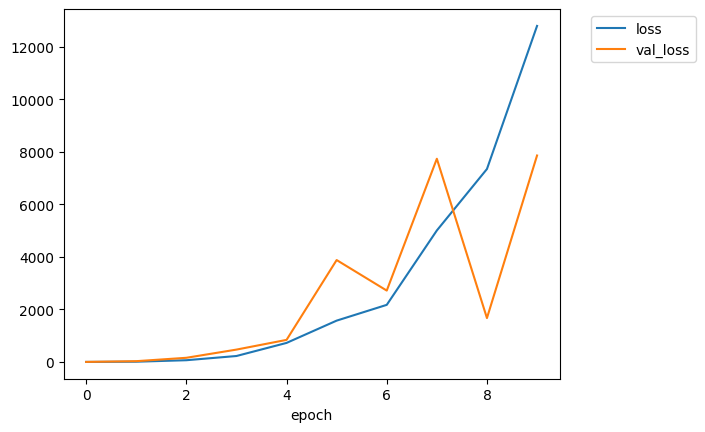

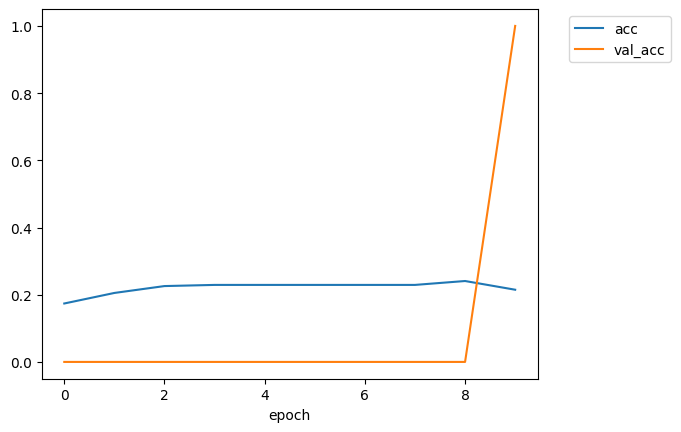

In [40]:
# Training model
nb_epochs=10
batch_size=100
training_history = mlp_model.fit(X_train,Y_train,validation_data=(X_test, Y_test),epochs=nb_epochs,batch_size=batch_size)

# Accuracy
loss_train, acc_train = mlp_model.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = mlp_model.evaluate(X_test, Y_test, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)

display_training_curves(training_history)

**QUESTION** Plot the confusion matrix and the classification report

**Tips:**

*   classification report link

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

*   Matrix confusion

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html





94/94 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      2905
           1       0.00      0.00      0.00        87

    accuracy                           0.97      2992
   macro avg       0.49      0.50      0.49      2992
weighted avg       0.94      0.97      0.96      2992



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


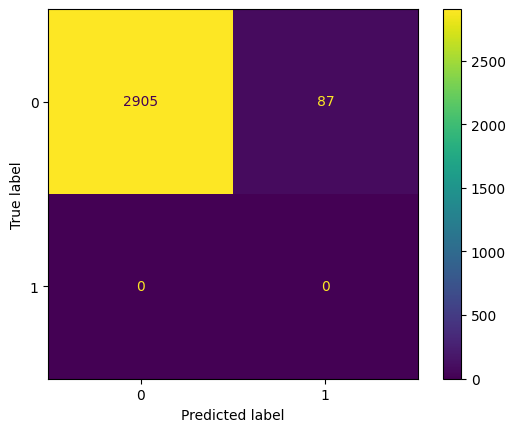

In [46]:
predictions = mlp_model.predict(X_test)
predictions = np.argmax(predictions, axis=1)
Y_test_clean = Y_test["Machine failure"]

# Classification report
print(classification_report(Y_test_clean, predictions))

# Matrix
confusion_matrix_1 = confusion_matrix(predictions,Y_test_clean)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_1)
disp.plot()

**ANALYSIS QUESTION** What do you observe? What can you conclude?

**Analyse**

If we observe the Machine_failure value, the model predict always Machine_failure = 0. This due to the dataset balance. In the dataset, the majority of machine have no failure. So, the AI "understand" that if it answers 0, the is true in 96,61%.

**Conclusion**

The model is overfitting. We need to adapt our dataset to avoid this problem.

## **3- Train model With balancing the dataset**

---

 Methods for rebalancing a dataset:


*   Use oversampling techniques (e.g., SMOTE) to generate synthetic data for minority classes


> https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html



*   Apply undersampling techniques (e.g., random undersampling, Tomek Links, Edited Nearest Neighbors) to reduce the majority class size



> https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html



*   Use class weighting during model training to penalize errors on minority classes



> https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=fr


**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [47]:
sm = SMOTE(sampling_strategy='auto')

# We copy our first filtered database
data_filtered_copy = data_filtered.copy()
# We inverse all 0 to 1 and 1 to 0 on Machine failure lines, to avoid to erase all machine failure line
data_filtered_copy['Machine failure'] = data_filtered_copy['Machine failure'].apply(lambda x: 1 if x == 0 else 0)

# We take all lines where sum > 1
condition = (
    ((data_filtered['Machine failure'] == 0) | (data_filtered['TWF'] == 0)) &
    ((data_filtered['Machine failure'] == 0) | (data_filtered['HDF'] == 0)) &
    ((data_filtered['Machine failure'] == 0) | (data_filtered['PWF'] == 0)) &
    ((data_filtered['Machine failure'] == 0) | (data_filtered['OSF'] == 0)) &
    ((data_filtered['TWF'] == 0) | (data_filtered['HDF'] == 0)) &
    ((data_filtered['TWF'] == 0) | (data_filtered['PWF'] == 0)) &
    ((data_filtered['TWF'] == 0) | (data_filtered['OSF'] == 0)) &
    ((data_filtered['HDF'] == 0) | (data_filtered['PWF'] == 0)) &
    ((data_filtered['HDF'] == 0) | (data_filtered['OSF'] == 0)) &
    ((data_filtered['PWF'] == 0) | (data_filtered['OSF'] == 0))
)

selected_data = data_filtered_copy[condition]
rejected_data = data_filtered_copy[condition == 0]

# Data for training
X = selected_data.loc[:,'Air temperature [K]':'Tool wear [min]']
Y = selected_data.loc[:, 'Machine failure':'OSF']

Y_array = Y.to_numpy()
X_SMOTE, Y_SMOTE = sm.fit_resample(X, Y_array) # SMOTE action without problem lines

Y_panda_SMOTE = pd.DataFrame(Y_SMOTE) # Df convert

X_rejected_data = rejected_data.loc[:,'Air temperature [K]':'Tool wear [min]']
Y_rejected_data = rejected_data.loc[:, 'Machine failure':'OSF']

# We concatenate lines lost to our second filtered dataset
Y_panda_SMOTE.columns = ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF']
X_panda_SMOTE_end = pd.concat([X_SMOTE, X_rejected_data], ignore_index=True)
Y_panda_SMOTE_end = pd.concat([Y_panda_SMOTE, Y_rejected_data], ignore_index=True)

X_train_SMOTE, X_test_SMOTE, Y_train_SMOTE, Y_test_SMOTE = train_test_split(X_panda_SMOTE_end, Y_panda_SMOTE_end, test_size=0.30, random_state=42) # Training data split


print(f"Shape X_train : {X_train_SMOTE.shape}")
print(f"Shape X_test : {X_test_SMOTE.shape}")
print(f"Shape Y_train : {Y_train_SMOTE.shape}")
print(f"Shape Y_test : {Y_test_SMOTE.shape}")

Shape X_train : (33861, 5)
Shape X_test : (14512, 5)
Shape Y_train : (33861, 5)
Shape Y_test : (14512, 5)


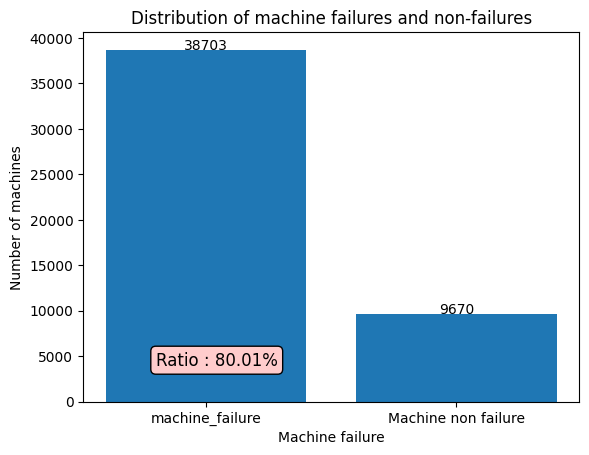

In [48]:
machine_non_failure = Y_panda_SMOTE_end[Y_panda_SMOTE_end['Machine failure'] == 1]
machine_failure = Y_panda_SMOTE_end[Y_panda_SMOTE_end['Machine failure'] == 0]

chart = plt.bar(["machine_failure", "Machine non failure"], [len(machine_failure),len(machine_non_failure)], width=0.8)
plt.title("Distribution of machine failures and non-failures")
plt.xlabel("Machine failure")
plt.ylabel("Number of machines")
plt.text(-0.2, 4000, "Ratio : " + str(round(100*len(machine_failure)/(len(machine_non_failure)+len(machine_failure)), 3)) + "%", fontsize=12, bbox=dict(boxstyle="round",ec=(0, 0, 0),fc=(1., 0.8, 0.8)))

add_text_to_bar_chart([len(machine_failure), len(machine_non_failure)], chart)

Text(0, 0.5, 'Number of machines')

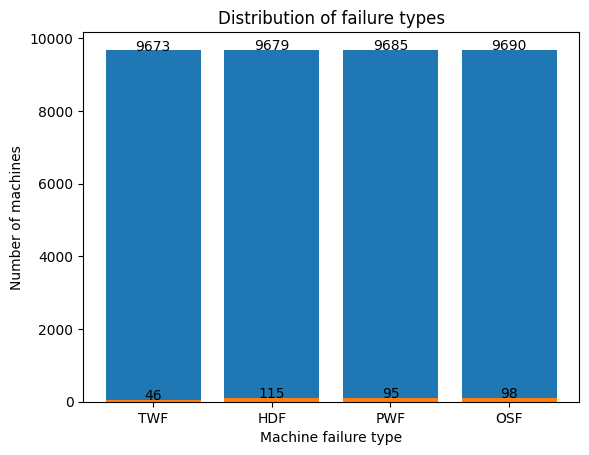

In [49]:
machine_TWF_after = machine_failure[machine_failure['TWF'] == 1]
machine_HDF_after = machine_failure[machine_failure['HDF'] == 1]
machine_PWF_after = machine_failure[machine_failure['PWF'] == 1]
machine_OSF_after = machine_failure[machine_failure['OSF'] == 1]

chart = plt.bar(["TWF", "HDF", "PWF", "OSF"], [len(machine_TWF_after),len(machine_HDF_after), len(machine_PWF_after), len(machine_OSF_after)], width=0.8)
add_text_to_bar_chart([len(machine_TWF_after),len(machine_HDF_after), len(machine_PWF_after), len(machine_OSF_after)], chart)
chart = plt.bar(["TWF", "HDF", "PWF", "OSF"], [len(machine_TWF),len(machine_HDF), len(machine_PWF), len(machine_OSF)], width=0.8)
add_text_to_bar_chart([len(machine_TWF),len(machine_HDF), len(machine_PWF), len(machine_OSF)], chart)

plt.title("Distribution of failure types")
plt.xlabel("Machine failure type")
plt.ylabel("Number of machines")


**ANALYSIS QUESTION:** Explain the choices you made to balance the dataset.

We need to homogenize our dataset. With SMOTE, we can create new data based on current data minority. In our case, we produce new machine with failure to avoid above bias. Moreover, we homogenize failure types, to avoid problems of unbalance dataset.  

**QUESTION:** Code below the model architecture


**TIP:** It could be interesting to keep it the same as before

In [56]:
inputs = tf.keras.Input(shape=(5,)) # INPUT layer
x = tf.keras.layers.Flatten()(inputs)

nb_layers = 3
nb_neurons = [32,64,128] # Number of neurons per layer
dropout_rate = 0.5


for i in range(nb_layers): # Layers
  x = tf.keras.layers.Dense(nb_neurons[i], activation='relu')(x)
  if(i == 2):
    x = tf.keras.layers.Dropout(dropout_rate)(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x) # OUTPUT layer with sofmax

mlp_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="mlp_model") # Create model

mlp_model.summary() # Display architecture

mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "mlp_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 5)]               0         
                                                                 
 flatten_6 (Flatten)         (None, 5)                 0         
                                                                 
 dense_22 (Dense)            (None, 32)                192       
                                                                 
 dense_23 (Dense)            (None, 64)                2112      
                                                                 
 dense_24 (Dense)            (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_25 (Dense)            (None, 5)                 64

**QUESTION** Code below the algorithms allowing to train model


Epoch 1/20
339/339 [==============================] - 4s 8ms/step - loss: 11.0896 - accuracy: 0.4817 - val_loss: 0.8040 - val_accuracy: 0.7238
Epoch 2/20
339/339 [==============================] - 1s 4ms/step - loss: 0.9613 - accuracy: 0.5866 - val_loss: 0.6857 - val_accuracy: 0.8041
Epoch 3/20
339/339 [==============================] - 2s 5ms/step - loss: 0.8705 - accuracy: 0.6300 - val_loss: 0.5667 - val_accuracy: 0.8337
Epoch 4/20
339/339 [==============================] - 2s 7ms/step - loss: 0.7988 - accuracy: 0.6606 - val_loss: 0.5918 - val_accuracy: 0.7659
Epoch 5/20
339/339 [==============================] - 2s 7ms/step - loss: 0.7280 - accuracy: 0.6835 - val_loss: 0.4696 - val_accuracy: 0.8729
Epoch 6/20
339/339 [==============================] - 2s 5ms/step - loss: 0.6764 - accuracy: 0.7088 - val_loss: 0.4520 - val_accuracy: 0.8281
Epoch 7/20
339/339 [==============================] - 2s 6ms/step - loss: 0.6101 - accuracy: 0.7516 - val_loss: 0.3198 - val_accuracy: 0.8971
Epoch

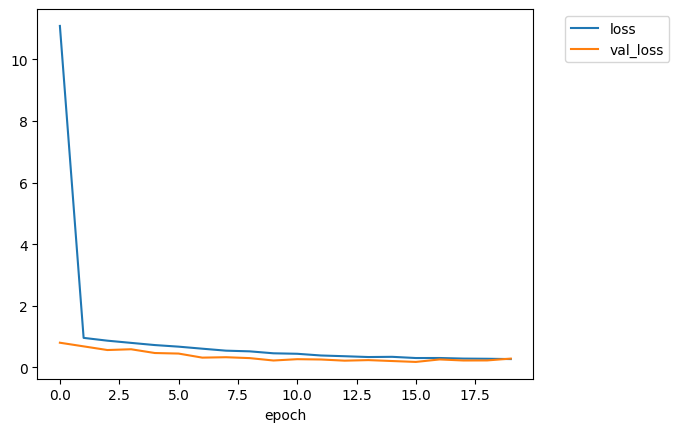

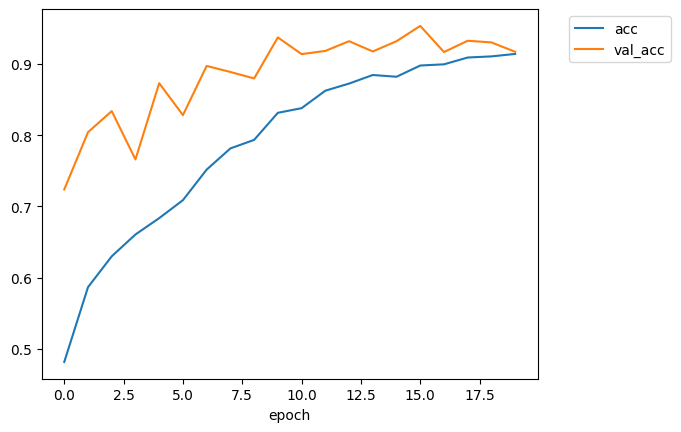

In [57]:
# Training model
nb_epochs=20
batch_size=100
training_history = mlp_model.fit(X_train_SMOTE,Y_train_SMOTE,validation_data=(X_test_SMOTE, Y_test_SMOTE),epochs=nb_epochs,batch_size=batch_size)

# Accuracy
loss_train, acc_train = mlp_model.evaluate(X_train_SMOTE, Y_train_SMOTE, batch_size=batch_size)
loss_test, acc_test = mlp_model.evaluate(X_test_SMOTE, Y_test_SMOTE, batch_size=batch_size)

print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)

display_training_curves(training_history)

**QUESTION** Plot the confusion matrix and the classification report

454/454 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

           0       1.00      0.75      0.86      2948
           1       0.90      0.94      0.92      2865
           2       0.89      0.90      0.89      2896
           3       0.93      1.00      0.96      2868
           4       0.89      1.00      0.94      2935

    accuracy                           0.92     14512
   macro avg       0.92      0.92      0.92     14512
weighted avg       0.92      0.92      0.91     14512



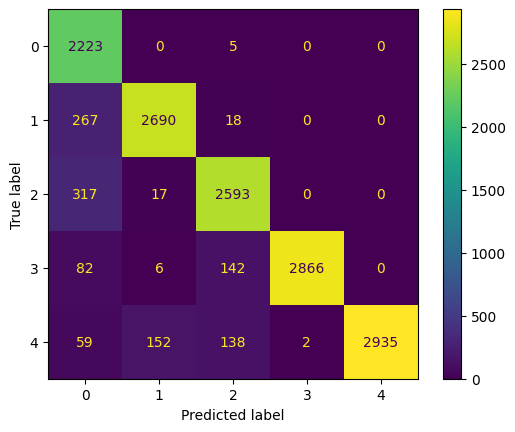

In [58]:
predictions = mlp_model.predict(X_test_SMOTE)
predictions = np.argmax(predictions, axis=1)
Y_test_SMOTE_argmax = np.argmax(Y_test_SMOTE.values, axis=1)

# Classification report
print(classification_report(Y_test_SMOTE_argmax, predictions))

# Matrix
confusion_matrix_1 = confusion_matrix(predictions,Y_test_SMOTE_argmax)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_1)
disp.plot()

**ANALYSIS QUESTION** What do you observe? What can you conclude?

**Analyse**

Our model is light, only 11,269 parameters and very good result. Training and test accurancy are equivalent and high : 92%. On the matrix, the repartition is coherent.

**Conclusion**

Our model is not underfitting or overfitting. It is ready to be implement on STM32 board.

In [59]:
np.save("Predict_machine_X.npy", X_test_SMOTE)
np.save("Predict_machine_Y.npy", Y_test_SMOTE)
mlp_model.save("Predict_machine.h5")